In [10]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from MH import MetroHast

import matplotlib.animation as animation

def run_anim(data,step_size,bins):
    n = int(len(data)/step_size)
    print(n)
    def update(curr):
        if curr == n:
            a.event_source.stop()
        plt.cla()
        bins = np.arange(-5, 5, 0.1)
        plt.hist(data[:curr*step_size], bins = bins, density=True, histtype='barstacked')
        plt.axis([-5, 5, 0, 0.5])
        plt.gca().set_title('Metropolis Hasting')
        plt.gca().set_ylabel('frequency')
        plt.gca().set_xlabel('value')
        plt.gca().annotate('n samples ={}'.format(curr*step_size), [3, 27])


    fig = plt.figure()
    a = animation.FuncAnimation(fig, update, interval = 100)

    plt.show()

In [11]:
def posterior(x):
    loc_1, scale_1 = 2, 1
    loc_2, scale_2 = -1, 0.5
    pdf = 0.5 * 1/np.sqrt(2*np.pi*scale_1*scale_1)*np.exp(-(x-loc_1)**2/2/scale_1/scale_1)
    pdf += 0.5 * 1/np.sqrt(2*np.pi*scale_2*scale_2)*np.exp(-(x-loc_2)**2/2/scale_2/scale_2)
    return pdf

sampler = MetroHast(post=posterior, sig=1)
res = sampler.run(10000, xinit=0) 

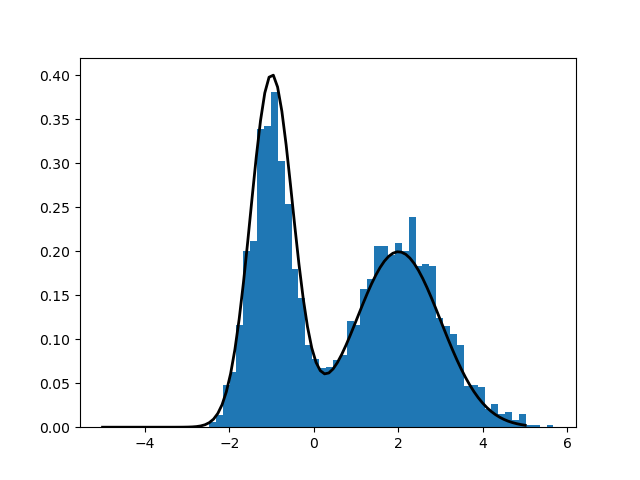

In [12]:
x = np.linspace(-5,5,100)
y = posterior(x)
plt.plot(x,y,color='k',lw=2)
plt.hist(res,bins=50,density=True,histtype='barstacked',color='C0')
plt.show()

500


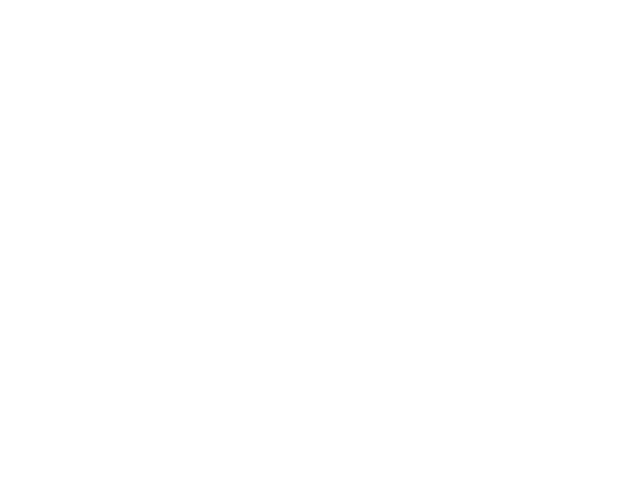

/Users/alanzhou/opt/anaconda3/envs/research/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6643: RuntimeWarning: invalid value encountered in divide
  tops = (tops / np.diff(bins)) / tops[-1].sum()


In [13]:
bins = np.arange(-5, 5, 0.1)
run_anim(data=res,step_size=20,bins=bins)

In [11]:
data

array([-1.04879671, -1.04879671, -1.08646869, -1.08646869, -1.08646869,
       -0.9678736 , -0.9678736 , -1.2344892 , -1.08564317,  0.06766665,
        0.84686144, -0.44767952, -0.16827517, -1.25843365, -1.25843365,
       -0.71122126, -0.79665189, -0.51423924, -0.51423924,  1.33355929,
        0.65278104,  2.35282811,  2.00472863,  1.12956266,  0.92500558,
        0.55383655, -0.06944333,  1.40376084,  2.11929793,  0.64127004,
       -1.13856163, -1.22874833, -1.22874833, -1.31589605, -1.31589605,
       -1.31589605, -1.31589605, -1.08327638, -0.67227248, -0.67227248,
       -0.67227248, -1.47277476, -1.47277476, -1.28839883, -1.10706004,
       -1.10706004, -0.44569508, -0.44569508, -1.69764682,  0.13446102,
        2.90351668,  2.90351668,  2.69703495,  2.92445866,  3.11884338,
        2.20850659,  1.73112783,  1.94584971,  1.94293204,  1.94293204,
       -0.18322718, -0.18322718, -1.78128615, -1.78128615, -1.78128615,
       -1.78128615, -1.78128615, -1.51151413, -1.51151413, -1.51

In [ ]:
# import matplotlib.animation as animation

# # def run_anim(data,number_of_frames):

# #     def update_hist(frame_num, frame_total, data):
# #         ind_data = int(len(data)*frame_num/frame_total)
# #         plt.cla()
# #         plt.hist(data[:ind_data],np.linspace(-5,5,100),histtype='barstacked',density=True)

# #     fig = plt.figure()
# #     hist = plt.hist(data,np.linspace(-5,5,100),histtype='barstacked',density=True)

# #     anim = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(number_of_frames, data, ) )
# #     plt.show(anim)
    
# # run_anim(data=res,number_of_frames=20)
# n = 20
# def update(curr):
#     if curr == n:
#         a.event_source.stop()
#     plt.cla()
#     bins = np.linspace(-5, 5, 100)
#     plt.hist(res[:curr], bins = bins)
#     plt.axis([-5, 5, 0, 2])
#     plt.gca().set_title('sampling the normal distribution')
#     plt.gca().set_ylabel('frequency')
#     plt.gca().set_xlabel('value')
#     # plt.gca().annotate('n={}'.format(curr), [3, 27])


# fig = plt.figure()
# a = animation.FuncAnimation(fig, update, interval = 100)

# plt.show()